Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
symbol = 'BTCUSDT'
percentage_to_trade = 0.9999
interval = '5m'
window_1 = 2
window_2 = 2
period = '1 day ago UTC'
min_periods = 14
api_key = 'yoyoyo'
api_secret = 'yeyeye'
kraken_key = 'yayaya'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly
!pip install stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from time import sleep
from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import subprocess
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
import pylab as pl
from IPython import display

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def right_join(left, right):
    if right.index[-1] == left.index[-1]:
        left = left.iloc[:-1].append(right)
    else:
        left = left.append(right)

    return left

def heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def ATR(ticker, min_periods=7):
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def BollingerBands(dataframe, n):
    df = dataframe.copy()
    df['MA'] = df['Adj Close'].rolling(n).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(n).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(n).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def average_directional_movement_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df

def commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

class renko:      
    def __init__(self):
        self.source_prices = []
        self.renko_prices = []
        self.renko_directions = []

    # Setting brick size. Auto mode is preferred, it uses history
    def set_brick_size(self, HLC_history = None, auto = True, brick_size = 10.0):
        if auto == True:
            self.brick_size = self.__get_optimal_brick_size(HLC_history.iloc[:, [0, 1, 2]])
        else:
            self.brick_size = brick_size
        return self.brick_size

    def __renko_rule(self, last_price):
        # Get the gap between two prices
        gap_div = int(float(last_price - self.renko_prices[-1]) / self.brick_size)
        is_new_brick = False
        start_brick = 0
        num_new_bars = 0

        # When we have some gap in prices
        if gap_div != 0:
            # Forward any direction (up or down)
            if (gap_div > 0 and (self.renko_directions[-1] > 0 or self.renko_directions[-1] == 0)) or (gap_div < 0 and (self.renko_directions[-1] < 0 or self.renko_directions[-1] == 0)):
                num_new_bars = gap_div
                is_new_brick = True
                start_brick = 0
            # Backward direction (up -> down or down -> up)
            elif np.abs(gap_div) >= 2: # Should be double gap at least
                num_new_bars = gap_div
                num_new_bars -= np.sign(gap_div)
                start_brick = 2
                is_new_brick = True
                self.renko_prices.append(self.renko_prices[-1] + 2 * self.brick_size * np.sign(gap_div))
                self.renko_directions.append(np.sign(gap_div))
            #else:
                #num_new_bars = 0

            if is_new_brick:
                # Add each brick
                for d in range(start_brick, np.abs(gap_div)):
                    self.renko_prices.append(self.renko_prices[-1] + self.brick_size * np.sign(gap_div))
                    self.renko_directions.append(np.sign(gap_div))

        return num_new_bars

    # Getting renko on history
    def build_history(self, prices):
        if len(prices) > 0:
            # Init by start values
            self.source_prices = prices
            self.renko_prices.append(prices.iloc[0])
            self.renko_directions.append(0)

            # For each price in history
            for p in self.source_prices[1:]:
                self.__renko_rule(p)

        return len(self.renko_prices)

    # Getting next renko value for last price
    def do_next(self, last_price):
        if len(self.renko_prices) == 0:
            self.source_prices.append(last_price)
            self.renko_prices.append(last_price)
            self.renko_directions.append(0)
            return 1
        else:
            self.source_prices.append(last_price)
            return self.__renko_rule(last_price)

    # Simple method to get optimal brick size based on ATR
    def __get_optimal_brick_size(self, HLC_history, atr_timeperiod = 14):
        brick_size = 0.0

        # If we have enough of data
        if HLC_history.shape[0] > atr_timeperiod:
            brick_size = np.median(talib.ATR(high = np.double(HLC_history.iloc[:, 0]), 
                                             low = np.double(HLC_history.iloc[:, 1]), 
                                             close = np.double(HLC_history.iloc[:, 2]), 
                                             timeperiod = atr_timeperiod)[atr_timeperiod:])

        return brick_size

    def evaluate(self, method='simple'):
        balance = 0
        sign_changes = 0
        price_ratio = len(self.source_prices) / len(self.renko_prices)

        if method == 'simple':
            for i in range(2, len(self.renko_directions)):
                if self.renko_directions[i] == self.renko_directions[i - 1]:
                    balance = balance + 1
                else:
                    balance = balance - 2
                    sign_changes = sign_changes + 1

            if sign_changes == 0:
                sign_changes = 1

            score = balance / sign_changes
            if score >= 0 and price_ratio >= 1:
                score = np.log(score + 1) * np.log(price_ratio)
            else:
                score = -1.0

            return {'balance': balance, 'sign_changes:': sign_changes, 
                    'price_ratio': price_ratio, 'score': score}

    def get_renko_prices(self):
        return self.renko_prices

    def get_renko_directions(self):
        return self.renko_directions

    def plot_renko(self, col_up = 'g', col_down = 'r'):
        fig, ax = plt.subplots(1, figsize=(20, 10))
        ax.set_title('Renko chart')
        ax.set_xlabel('Renko bars')
        ax.set_ylabel('Price')

        # Calculate the limits of axes
        ax.set_xlim(0.0, 
                    len(self.renko_prices) + 1.0)
        ax.set_ylim(np.min(self.renko_prices) - 3.0 * self.brick_size, 
                    np.max(self.renko_prices) + 3.0 * self.brick_size)

        # Plot each renko bar
        for i in range(1, len(self.renko_prices)):
            # Set basic params for patch rectangle
            col = col_up if self.renko_directions[i] == 1 else col_down
            x = i
            y = self.renko_prices[i] - self.brick_size if self.renko_directions[i] == 1 else self.renko_prices[i]
            height = self.brick_size

            # Draw bar with params
            ax.add_patch(
                patches.Rectangle(
                    (x, y),   # (x,y)
                    1.0,     # width
                    self.brick_size, # height
                    facecolor = col
                )
            )

        plt.show()

def make_OHLC_dataset(dataset, interval=interval):
    dataset = dataset.resample(interval)
    dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})
    dataset = dataset.dropna(axis='index')['price']
    dataset = dataset.rename(columns={'first': 'open', 
                                      'max': 'high', 
                                      'min': 'low', 
                                      'last': 'close'})

    return dataset

def download_dataset(symbol=symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume', 
                                             'Number of trades']]

    dataset_downloaded.set_index('time', inplace=True)

    return dataset_downloaded

'''
def download_dataset(symbol=symbol, interval=interval):
    four_hours = 14400
    millisecond = 1000

    dataset = client.get_historical_trades(symbol=symbol)
    dataset = pd.DataFrame(dataset, columns=list(dataset[0].keys()), 
                           index=list(map(lambda row: \
                                              int(row['time'] / millisecond) - \
                                              four_hours, 
                                          dataset)))

    dataset.drop(columns=['time'], inplace=True)
    dataset.index.name = 'timestamp'
    dataset['timestamp'] = dataset.index.to_series()
    dataset = dataset[['id', 'price', 'timestamp']]
    dataset.index = list(map(lambda timestamp: \
                                 datetime.datetime.fromtimestamp(timestamp), 
                             dataset.index))

    dataset = make_OHLC_dataset(dataset, interval=interval)

    return dataset
'''

def compute_balances_BTCUSDT(pair=symbol, first=8, second=8):
    buy_USDT_balance = float(client.get_asset_balance(asset=second)['free'])
    buy_BTC_last_price = float(client.get_ticker(symbol=symbol)['lastPrice'])
    buy_BTC_balance = buy_USDT_balance / buy_BTC_last_price
    sell_BTC_balance = float(client.get_asset_balance(asset=first)['free'])
    sell_USDT_last_price = float(client.get_ticker(symbol=symbol)['lastPrice'])
    sell_USDT_balance = sell_BTC_balance * sell_USDT_last_price
    USDT_balance_combined = sell_USDT_balance + buy_USDT_balance
    BTC_balance_combined = buy_BTC_balance + sell_BTC_balance

    return buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined

def print_balances_BTCUSDT(buy_USDT_balance, 
                           buy_BTC_last_price, 
                           buy_BTC_balance, 
                           sell_BTC_balance, 
                           sell_USDT_last_price, 
                           sell_USDT_balance, 
                           USDT_balance_combined, 
                           BTC_balance_combined):

    print('buy_USDT_balance: ', buy_USDT_balance)
    print('buy_BTC_last_price: ', buy_BTC_last_price)
    print('buy_BTC_balance: ', buy_BTC_balance)
    print('sell_BTC_balance: ', sell_BTC_balance)
    print('sell_USDT_last_price: ', sell_USDT_last_price)
    print('sell_USDT_balance: ', sell_USDT_balance)
    print('USDT_balance_combined: ', USDT_balance_combined)
    print('BTC_balance_combined: ', BTC_balance_combined)

def get_symbol_on_Binance(symbol, quote_precision=8):
    last_price = [ticker['price'] for ticker in client.get_all_tickers() if ticker['symbol'] == symbol][0]
    last_price = "{:0.0{}f}".format(float(last_price), quote_precision)
    return last_price

def get_BTCUSD_price():
    api_call = 'curl https://api.cryptowat.ch/markets/bitstamp/btcusd/price?apikey=' + kraken_key
    json_response_serialized = subprocess.check_output(api_call, shell=True)
    json_response = json.loads(json_response_serialized)
    price = json_response['result']['price']
    return price

Download cryptocurrency symbol data.

In [5]:
client = Client(api_key, api_secret)
symbol_info = client.get_symbol_info(symbol)
symbol_info

{'symbol': 'BTCUSDT',
 'status': 'TRADING',
 'baseAsset': 'BTC',
 'baseAssetPrecision': 8,
 'quoteAsset': 'USDT',
 'quotePrecision': 8,
 'baseCommissionPrecision': 8,
 'quoteCommissionPrecision': 8,
 'orderTypes': ['LIMIT',
  'LIMIT_MAKER',
  'MARKET',
  'STOP_LOSS_LIMIT',
  'TAKE_PROFIT_LIMIT'],
 'icebergAllowed': True,
 'ocoAllowed': True,
 'quoteOrderQtyMarketAllowed': True,
 'isSpotTradingAllowed': True,
 'isMarginTradingAllowed': True,
 'filters': [{'filterType': 'PRICE_FILTER',
   'minPrice': '0.01000000',
   'maxPrice': '1000000.00000000',
   'tickSize': '0.01000000'},
  {'filterType': 'PERCENT_PRICE',
   'multiplierUp': '5',
   'multiplierDown': '0.2',
   'avgPriceMins': 5},
  {'filterType': 'LOT_SIZE',
   'minQty': '0.00000100',
   'maxQty': '9000.00000000',
   'stepSize': '0.00000100'},
  {'filterType': 'MIN_NOTIONAL',
   'minNotional': '10.00000000',
   'applyToMarket': True,
   'avgPriceMins': 5},
  {'filterType': 'ICEBERG_PARTS', 'limit': 10},
  {'filterType': 'MARKET_LOT_

In [6]:
first = symbol_info['baseAsset']
first

'BTC'

In [7]:
second = symbol_info['quoteAsset']
second

'USDT'

In [8]:
dataset_downloaded = download_dataset()
dataset_downloaded

open           high            low  \
time                                                               
2020-04-10 12:15:00  6885.87000000  6890.99000000  6874.73000000   
2020-04-10 12:20:00  6886.13000000  6893.65000000  6883.06000000   
2020-04-10 12:25:00  6886.72000000  6893.85000000  6877.40000000   
2020-04-10 12:30:00  6886.65000000  6895.00000000  6885.46000000   
2020-04-10 12:35:00  6893.00000000  6909.68000000  6892.86000000   
2020-04-10 12:40:00  6908.35000000  6911.60000000  6895.00000000   
2020-04-10 12:45:00  6904.26000000  6904.99000000  6899.03000000   
2020-04-10 12:50:00  6903.86000000  6909.16000000  6896.61000000   
2020-04-10 12:55:00  6904.74000000  6910.00000000  6901.66000000   
2020-04-10 13:00:00  6909.99000000  6929.00000000  6909.31000000   
2020-04-10 13:05:00  6917.22000000  6931.93000000  6917.01000000   
2020-04-10 13:10:00  6929.25000000  6929.82000000  6921.10000000   
2020-04-10 13:15:00  6925.37000000  6930.00000000  6923.19000000   
2020-04-10 13:20:00  6928.27000000  6930.00000000  6927.62000000   
2020-04-10 13:25:00  6928.95000000  6929.04000000  6901.54000000   
2020-04-10 13:30:00  6902.70000000  6911.72000000  6882.72000000   
2020-04-10 13:35:00  6888.99000000  6900.35000000  6888.99000000   
2020-04-10 13:40:00  6899.40000000  6911.87000000  6899.23000000   
2020-04-10 13:45:00  6903.01000000  6904.60000000  6890.00000000   
2020-04-10 13:50:00  6894.95000000  6898.29000000  6891.53000000   
2020-04-10 13:55:00  6891.99000000  6894.49000000  6878.05000000   
2020-04-10 14:00:00  6894.28000000  6910.00000000  6894.15000000   
2020-04-10 14:05:00  6908.77000000  6916.41000000  6901.71000000   
2020-04-10 14:10:00  6910.06000000  6914.18000000  6896.74000000   
2020-04-10 14:15:00  6897.39000000  6903.51000000  6890.69000000   
2020-04-10 14:20:00  6901.78000000  6911.65000000  6894.82000000   
2020-04-10 14:25:00  6905.01000000  6907.43000000  6894.72000000   
2020-04-10 14:30:00  6897.04000000  6899.83000000  6870.03000000   
2020-04-10 14:35:00  6880.00000000  6889.98000000  6875.03000000   
2020-04-10 14:40:00  6875.94000000  6876.66000000  6854.19000000   
...                            ...            ...            ...   
2020-04-11 09:45:00  6811.81000000  6828.17000000  6811.00000000   
2020-04-11 09:50:00  6818.92000000  6822.99000000  6806.45000000   
2020-04-11 09:55:00  6811.85000000  6814.00000000  6771.44000000   
2020-04-11 10:00:00  6785.53000000  6802.56000000  6778.54000000   
2020-04-11 10:05:00  6784.31000000  6794.99000000  6783.03000000   
2020-04-11 10:10:00  6789.93000000  6803.55000000  6785.00000000   
2020-04-11 10:15:00  6799.24000000  6800.00000000  6786.07000000   
2020-04-11 10:20:00  6786.49000000  6799.32000000  6785.88000000   
2020-04-11 10:25:00  6794.74000000  6807.00000000  6793.48000000   
2020-04-11 10:30:00  6799.55000000  6799.72000000  6789.00000000   
2020-04-11 10:35:00  6790.50000000  6803.10000000  6790.40000000   
2020-04-11 10:40:00  6800.94000000  6801.03000000  6790.58000000   
2020-04-11 10:45:00  6793.60000000  6799.28000000  6788.09000000   
2020-04-11 10:50:00  6791.23000000  6804.09000000  6791.00000000   
2020-04-11 10:55:00  6796.48000000  6828.79000000  6796.40000000   
2020-04-11 11:00:00  6811.09000000  6823.99000000  6800.00000000   
2020-04-11 11:05:00  6820.95000000  6828.62000000  6814.98000000   
2020-04-11 11:10:00  6822.03000000  6824.41000000  6801.18000000   
2020-04-11 11:15:00  6812.63000000  6813.70000000  6802.60000000   
2020-04-11 11:20:00  6805.35000000  6819.43000000  6805.00000000   
2020-04-11 11:25:00  6810.85000000  6813.29000000  6797.77000000   
2020-04-11 11:30:00  6810.36000000  6812.00000000  6802.40000000   
2020-04-11 11:35:00  6804.33000000  6810.00000000  6798.01000000   
2020-04-11 11:40:00  6803.53000000  6803.53000000  6789.03000000   
2020-04-11 11:45:00  6794.96000000  6800.00000000  6785.88000000   
2020-04-11 11:50:00  6793.81000000  6795.00000000  6786.00000000   
2020-04-11 11:55:0

Download testing area -->

<-- End of download testing area.

*** To avoid downloading multiple times, restart here. ***

In [9]:
dataset = dataset_downloaded.copy()
dataset

open           high            low  \
time                                                               
2020-04-10 12:15:00  6885.87000000  6890.99000000  6874.73000000   
2020-04-10 12:20:00  6886.13000000  6893.65000000  6883.06000000   
2020-04-10 12:25:00  6886.72000000  6893.85000000  6877.40000000   
2020-04-10 12:30:00  6886.65000000  6895.00000000  6885.46000000   
2020-04-10 12:35:00  6893.00000000  6909.68000000  6892.86000000   
2020-04-10 12:40:00  6908.35000000  6911.60000000  6895.00000000   
2020-04-10 12:45:00  6904.26000000  6904.99000000  6899.03000000   
2020-04-10 12:50:00  6903.86000000  6909.16000000  6896.61000000   
2020-04-10 12:55:00  6904.74000000  6910.00000000  6901.66000000   
2020-04-10 13:00:00  6909.99000000  6929.00000000  6909.31000000   
2020-04-10 13:05:00  6917.22000000  6931.93000000  6917.01000000   
2020-04-10 13:10:00  6929.25000000  6929.82000000  6921.10000000   
2020-04-10 13:15:00  6925.37000000  6930.00000000  6923.19000000   
2020-04-10 13:20:00  6928.27000000  6930.00000000  6927.62000000   
2020-04-10 13:25:00  6928.95000000  6929.04000000  6901.54000000   
2020-04-10 13:30:00  6902.70000000  6911.72000000  6882.72000000   
2020-04-10 13:35:00  6888.99000000  6900.35000000  6888.99000000   
2020-04-10 13:40:00  6899.40000000  6911.87000000  6899.23000000   
2020-04-10 13:45:00  6903.01000000  6904.60000000  6890.00000000   
2020-04-10 13:50:00  6894.95000000  6898.29000000  6891.53000000   
2020-04-10 13:55:00  6891.99000000  6894.49000000  6878.05000000   
2020-04-10 14:00:00  6894.28000000  6910.00000000  6894.15000000   
2020-04-10 14:05:00  6908.77000000  6916.41000000  6901.71000000   
2020-04-10 14:10:00  6910.06000000  6914.18000000  6896.74000000   
2020-04-10 14:15:00  6897.39000000  6903.51000000  6890.69000000   
2020-04-10 14:20:00  6901.78000000  6911.65000000  6894.82000000   
2020-04-10 14:25:00  6905.01000000  6907.43000000  6894.72000000   
2020-04-10 14:30:00  6897.04000000  6899.83000000  6870.03000000   
2020-04-10 14:35:00  6880.00000000  6889.98000000  6875.03000000   
2020-04-10 14:40:00  6875.94000000  6876.66000000  6854.19000000   
...                            ...            ...            ...   
2020-04-11 09:45:00  6811.81000000  6828.17000000  6811.00000000   
2020-04-11 09:50:00  6818.92000000  6822.99000000  6806.45000000   
2020-04-11 09:55:00  6811.85000000  6814.00000000  6771.44000000   
2020-04-11 10:00:00  6785.53000000  6802.56000000  6778.54000000   
2020-04-11 10:05:00  6784.31000000  6794.99000000  6783.03000000   
2020-04-11 10:10:00  6789.93000000  6803.55000000  6785.00000000   
2020-04-11 10:15:00  6799.24000000  6800.00000000  6786.07000000   
2020-04-11 10:20:00  6786.49000000  6799.32000000  6785.88000000   
2020-04-11 10:25:00  6794.74000000  6807.00000000  6793.48000000   
2020-04-11 10:30:00  6799.55000000  6799.72000000  6789.00000000   
2020-04-11 10:35:00  6790.50000000  6803.10000000  6790.40000000   
2020-04-11 10:40:00  6800.94000000  6801.03000000  6790.58000000   
2020-04-11 10:45:00  6793.60000000  6799.28000000  6788.09000000   
2020-04-11 10:50:00  6791.23000000  6804.09000000  6791.00000000   
2020-04-11 10:55:00  6796.48000000  6828.79000000  6796.40000000   
2020-04-11 11:00:00  6811.09000000  6823.99000000  6800.00000000   
2020-04-11 11:05:00  6820.95000000  6828.62000000  6814.98000000   
2020-04-11 11:10:00  6822.03000000  6824.41000000  6801.18000000   
2020-04-11 11:15:00  6812.63000000  6813.70000000  6802.60000000   
2020-04-11 11:20:00  6805.35000000  6819.43000000  6805.00000000   
2020-04-11 11:25:00  6810.85000000  6813.29000000  6797.77000000   
2020-04-11 11:30:00  6810.36000000  6812.00000000  6802.40000000   
2020-04-11 11:35:00  6804.33000000  6810.00000000  6798.01000000   
2020-04-11 11:40:00  6803.53000000  6803.53000000  6789.03000000   
2020-04-11 11:45:00  6794.96000000  6800.00000000  6785.88000000   
2020-04-11 11:50:00  6793.81000000  6795.00000000  6786.00000000   
2020-04-11 11:55:0

In [10]:
for window_SMA in range(1, 5):
    for window_EWM in range(1, 5):
        print('window_SMA: ', window_SMA)
        print('window_EWM: ', window_EWM)
        heikin_ashi_dataset_test = heikin_ashi(dataset.rolling(window=window_SMA).mean().fillna(method='backfill', axis='index')).ewm(span=window_EWM).mean().fillna(method='backfill', axis='index')
        fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_dataset_test.index.to_series(), 
                                             open=heikin_ashi_dataset_test['open'], 
                                             high=heikin_ashi_dataset_test['high'], 
                                             low=heikin_ashi_dataset_test['low'], 
                                             close=heikin_ashi_dataset_test['close'])])

        fig.show()

window_SMA:  1
window_EWM:  1


window_SMA:  1
window_EWM:  2


window_SMA:  1
window_EWM:  3


window_SMA:  1
window_EWM:  4


window_SMA:  2
window_EWM:  1


window_SMA:  2
window_EWM:  2


window_SMA:  2
window_EWM:  3


window_SMA:  2
window_EWM:  4


window_SMA:  3
window_EWM:  1


window_SMA:  3
window_EWM:  2


window_SMA:  3
window_EWM:  3


window_SMA:  3
window_EWM:  4


window_SMA:  4
window_EWM:  1


window_SMA:  4
window_EWM:  2


window_SMA:  4
window_EWM:  3


window_SMA:  4
window_EWM:  4


/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



open         high          low        close
2020-04-10 12:15:00  6886.000000  6892.320000  6878.895000  6885.910000
2020-04-10 12:20:00  6885.966250  6892.320000  6878.895000  6885.910000
2020-04-10 12:25:00  6885.942885  6893.310000  6879.819231  6886.445673
2020-04-10 12:30:00  6886.189422  6894.062625  6880.906500  6887.474594
2020-04-10 12:35:00  6886.825132  6899.603678  6885.078711  6892.800114
2020-04-10 12:40:00  6889.802148  6906.971332  6889.221608  6899.481703
2020-04-10 12:45:00  6894.634019  6907.854181  6894.419579  6902.413575
2020-04-10 12:50:00  6898.519979  6907.334648  6896.686872  6903.012950
2020-04-10 12:55:00  6900.764964  6908.831625  6898.319040  6904.400220
2020-04-10 13:00:00  6902.582030  6915.943996  6901.766750  6909.209322
2020-04-10 13:05:00  6905.895451  6925.624720  6905.623694  6916.636482
2020-04-10 13:10:00  6911.265872  6929.124913  6911.175286  6922.323838
2020-04-10 13:15:00  6916.794816  6929.648305  6916.764621  6925.102948
2020-04-10 13:20:00  6920.948867  6929.882768  6920.938802  6926.844316
2020-04-10 13:25:00  6923.896587  6929.640923  6916.699601  6923.728939
2020-04-10 13:30:00  6923.812761  6925.727539  6900.319866  6911.964646
2020-04-10 13:35:00  6917.888703  6918.526962  6890.676622  6900.969882
2020-04-10 13:40:00  6909.429292  6910.248987  6892.965541  6899.534961
2020-04-10 13:45:00  6904.482126  6908.906329  6894.065180  6900.309987
2020-04-10 13:50:00  6902.396057  6903.932110  6891.865060  6897.557496
2020-04-10 13:55:00  6899.976776  6900.488794  6887.148353  6893.829165
2020-04-10 14:00:00  6896.902971  6901.659598  6886.449451  6895.123888
2020-04-10 14:05:00  6896.013430  6909.356533  6892.528923  6902.079629
2020-04-10 14:10:00  6899.046530  6913.315511  6896.992974  6905.328210
2020-04-10 14:15:00  6902.187370  6910.335170  6894.807658  6902.755237
2020-04-10 14:20:00  6902.471303  6908.498390  6893.439219  6901.470912
2020-04-10 14:25:00  6901.971108  6909.192797  6894.326406  6901.944471
2020-04-10 14:30:00  6901.957789  6905.484266  6886.358802  6896.573157
2020-04-10 14:35:00  6899.265473  6900.440965  6877.139601  6887.910219
2020-04-10 14:40:00  6893.587846  6893.979677  6868.786534  6878.265073
...                          ...          ...          ...          ...
2020-04-11 09:45:00  6806.161068  6818.199086  6804.768119  6810.556580
2020-04-11 09:50:00  6808.358824  6823.119695  6807.406040  6814.308860
2020-04-11 09:55:00  6811.333842  6820.036565  6795.098680  6808.371287
2020-04-11 10:00:00  6809.852564  6812.753472  6781.692893  6797.284596
2020-04-11 10:05:00  6803.568580  6804.535549  6781.087631  6791.030699
2020-04-11 10:10:00  6797.299639  6801.025183  6783.039210  6791.178566
2020-04-11 10:15:00  6794.239103  6801.525061  6784.703070  6792.844522
2020-04-11 10:20:00  6793.541812  6800.281687  6785.551023  6792.433174
2020-04-11 10:25:00  6792.987493  6802.200562  6788.303674  6794.218558
2020-04-11 10:30:00  6793.603026  6802.973521  6790.261225  6795.870353
2020-04-11 10:35:00  6794.736689  6801.931174  6789.887075  6795.629284
2020-04-11 10:40:00  6795.182987  6802.020391  6790.289025  6796.128095
2020-04-11 10:45:00  6795.655541  6800.776797  6789.653008  6795.185198
2020-04-11 10:50:00  6795.420369  6801.382266  6789.581003  6794.706733
2020-04-11 10:55:00  6795.063551  6811.420755  6792.327001  6799.613911
2020-04-11 11:00:00  6797.338731  6821.400252  6796.242334  6807.270470
2020-04-11 11:05:00  6802.304601  6824.670084  6801.939135  6814.312657
2020-04-11 11:10:00  6808.308629  6825.900028  6806.033045  6817.015886
2020-04-11 11:15:00  6812.662257  6821.336676  6803.271015  6813.548629
2020-04-11 11:20:00  6813.105443  6818.155559  6803.623672  6810.791210
2020-04-11 11:25:00  6811.948326  6816.958520  6802.131224  6809.677903
2020-04-11 11:30:00  6810.813115  6814.082840  6800.767075  6808.308468
2020-04-11 11:35:00  6809.560791  6812.027613  6800.392358  6806.539489
2020-04-11 11:40:00  6808.050140  6808.872414  6795.810786  6802.843

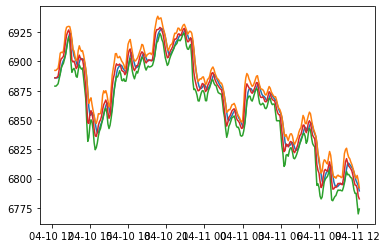

In [11]:
heikin_ashi_dataset = heikin_ashi(dataset.rolling(window=window_1).mean().fillna(method='backfill', axis='index')).ewm(span=window_2).mean().fillna(method='backfill', axis='index')
plt.plot(heikin_ashi_dataset)
heikin_ashi_dataset

In [12]:
fig = go.Figure(data=[go.Candlestick(x=heikin_ashi_dataset.index.to_series(), 
                                     open=heikin_ashi_dataset['open'], 
                                     high=heikin_ashi_dataset['high'], 
                                     low=heikin_ashi_dataset['low'], 
                                     close=heikin_ashi_dataset['close'])])

fig.show()

2020-04-10 12:15:00    0
2020-04-10 12:20:00    0
2020-04-10 12:25:00    1
2020-04-10 12:30:00    1
2020-04-10 12:35:00    1
2020-04-10 12:40:00    1
2020-04-10 12:45:00    1
2020-04-10 12:50:00    1
2020-04-10 12:55:00    1
2020-04-10 13:00:00    1
2020-04-10 13:05:00    1
2020-04-10 13:10:00    1
2020-04-10 13:15:00    1
2020-04-10 13:20:00    1
2020-04-10 13:25:00    0
2020-04-10 13:30:00    0
2020-04-10 13:35:00    0
2020-04-10 13:40:00    0
2020-04-10 13:45:00    0
2020-04-10 13:50:00    0
2020-04-10 13:55:00    0
2020-04-10 14:00:00    0
2020-04-10 14:05:00    1
2020-04-10 14:10:00    1
2020-04-10 14:15:00    1
2020-04-10 14:20:00    0
2020-04-10 14:25:00    0
2020-04-10 14:30:00    0
2020-04-10 14:35:00    0
2020-04-10 14:40:00    0
                      ..
2020-04-11 09:45:00    1
2020-04-11 09:50:00    1
2020-04-11 09:55:00    0
2020-04-11 10:00:00    0
2020-04-11 10:05:00    0
2020-04-11 10:10:00    0
2020-04-11 10:15:00    0
2020-04-11 10:20:00    0
2020-04-11 10:25:00    1


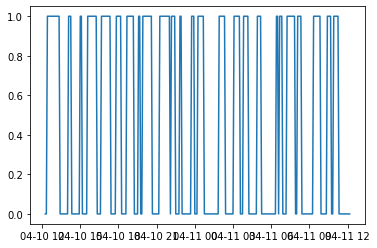

In [13]:
trend = ((heikin_ashi_dataset['close'] - heikin_ashi_dataset['open']) > 0).astype(int)
plt.plot(trend)
trend

In [14]:
CCI = commodity_channel_index(heikin_ashi_dataset, min_periods=20)
CCI_before = CCI.copy()
CCI

2020-04-10 12:15:00         NaN
2020-04-10 12:20:00         NaN
2020-04-10 12:25:00         NaN
2020-04-10 12:30:00         NaN
2020-04-10 12:35:00         NaN
2020-04-10 12:40:00         NaN
2020-04-10 12:45:00         NaN
2020-04-10 12:50:00         NaN
2020-04-10 12:55:00         NaN
2020-04-10 13:00:00         NaN
2020-04-10 13:05:00         NaN
2020-04-10 13:10:00         NaN
2020-04-10 13:15:00         NaN
2020-04-10 13:20:00         NaN
2020-04-10 13:25:00         NaN
2020-04-10 13:30:00         NaN
2020-04-10 13:35:00         NaN
2020-04-10 13:40:00         NaN
2020-04-10 13:45:00         NaN
2020-04-10 13:50:00   -0.471312
2020-04-10 13:55:00   -0.835902
2020-04-10 14:00:00   -0.860515
2020-04-10 14:05:00   -0.371985
2020-04-10 14:10:00   -0.114806
2020-04-10 14:15:00   -0.428440
2020-04-10 14:20:00   -0.596536
2020-04-10 14:25:00   -0.529158
2020-04-10 14:30:00   -1.044940
2020-04-10 14:35:00   -1.598658
2020-04-10 14:40:00   -1.965919
                         ...   
2020-04-

In [15]:
brick_size = ATR(dataset, min_periods=min_periods).median()
brick_size

16.145957412911994

                            open         high          low        close  \
time                                                                      
2020-04-10 12:15:00  6862.031900  6878.177858  6862.031900  6878.177858   
2020-04-10 12:35:00  6878.177858  6894.323815  6878.177858  6894.323815   
2020-04-10 13:00:00  6894.323815  6910.469773  6894.323815  6910.469773   
2020-04-10 13:05:00  6910.469773  6926.615730  6910.469773  6926.615730   
2020-04-10 13:30:00  6910.469773  6910.469773  6894.323815  6894.323815   
2020-04-10 14:35:00  6894.323815  6894.323815  6878.177858  6878.177858   
2020-04-10 14:40:00  6878.177858  6878.177858  6862.031900  6862.031900   
2020-04-10 14:45:00  6862.031900  6862.031900  6845.885943  6845.885943   
2020-04-10 14:45:00  6845.885943  6845.885943  6829.739986  6829.739986   
2020-04-10 15:00:00  6845.885943  6862.031900  6845.885943  6862.031900   
2020-04-10 15:20:00  6845.885943  6845.885943  6829.739986  6829.739986   
2020-04-10 16:00:00  6845

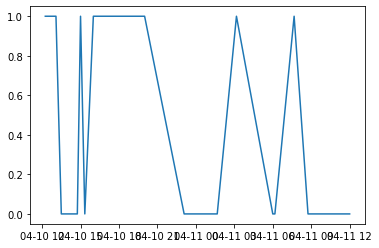

In [16]:
renko = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
renko.index.name = 'date'
renko = Renko(renko.reset_index())
renko.brick_size = brick_size
renko = renko.get_ohlc_data().set_index('date')
renko.index.name = 'time'
print(renko)
plt.plot(renko.uptrend)
plt.show()

In [17]:
ADX = average_directional_movement_index(dataset, n=14, n_ADX=14).ADX.dropna()
ADX

time
2020-04-10 14:25:00    0.185561
2020-04-10 14:30:00    0.213749
2020-04-10 14:35:00    0.264274
2020-04-10 14:40:00    0.328496
2020-04-10 14:45:00    0.382636
2020-04-10 14:50:00    0.414208
2020-04-10 14:55:00    0.401306
2020-04-10 15:00:00    0.396648
2020-04-10 15:05:00    0.399400
2020-04-10 15:10:00    0.417003
2020-04-10 15:15:00    0.442655
2020-04-10 15:20:00    0.447071
2020-04-10 15:25:00    0.450867
2020-04-10 15:30:00    0.404913
2020-04-10 15:35:00    0.365331
2020-04-10 15:40:00    0.341524
2020-04-10 15:45:00    0.316705
2020-04-10 15:50:00    0.288314
2020-04-10 15:55:00    0.289465
2020-04-10 16:00:00    0.290460
2020-04-10 16:05:00    0.298566
2020-04-10 16:10:00    0.311505
2020-04-10 16:15:00    0.277962
2020-04-10 16:20:00    0.258765
2020-04-10 16:25:00    0.239568
2020-04-10 16:30:00    0.239199
2020-04-10 16:35:00    0.257776
2020-04-10 16:40:00    0.285756
2020-04-10 16:45:00    0.309986
2020-04-10 16:50:00    0.346813
                         ...   
202

In [18]:
base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
base_asset_precision

8

In [19]:
quote_precision = client.get_symbol_info(symbol)['quotePrecision']
quote_precision

8

In [20]:
tick_size = float([ticker['tickSize'] for ticker in client.get_symbol_info('BTCUSDT')['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0])
tick_size

0.01

In [21]:
step_size = float([ticker['stepSize'] for ticker in client.get_symbol_info('BTCUSDT')['filters'] if ticker['filterType'] == 'LOT_SIZE'][0])
step_size

1e-06

In [22]:
ticks = {}
for filt in client.get_symbol_info(symbol)['filters']:
    if filt['filterType'] == 'LOT_SIZE':
        ticks[first] = filt['stepSize'].find('1') - 2
        break

ticks

{'BTC': 5}

In [23]:
BTCUSDT_price = get_symbol_on_Binance(symbol, quote_precision=quote_precision)
BTC_price_last_order = float(dataset['close'].iloc[-1])
BTC_price_last = float(dataset['close'].iloc[-1])
BTC_price_now = float(dataset['close'].iloc[-1])
float(BTCUSDT_price)

6781.03

In [24]:
#BTCUSD_price = get_BTCUSD_price()
#BTCUSD_price_before = BTCUSD_price
#BTCUSD_price_just_before = BTCUSD_price
#BTCUSD_price

In [25]:
dataset = dataset[['open', 'high', 'low', 'close', 'volume']]
dataset = dataset.astype(float)

In [26]:
buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined = compute_balances_BTCUSDT(pair=symbol, first=first, second=second)
BTC_balance_combined_before = BTC_balance_combined
USDT_balance_combined_before = USDT_balance_combined

In [27]:
if buy_BTC_balance > sell_BTC_balance:
    position = 'sell'
elif sell_BTC_balance > buy_BTC_balance:
    position = 'buy'

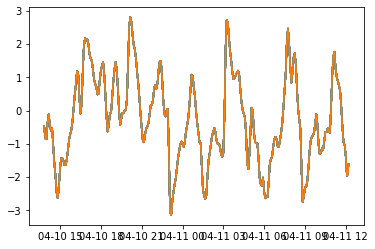

In [ ]:
def process_message(msg):
    global dataset, trend, position, min_periods, BTC_price_now, BTC_price_last, BTC_price_last_order, buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined, RSI_6, RSI_24, BTC_balance_combined_before, USDT_balance_combined_before, renko, brick_size, CCI, CCI_before
    four_hours = 14400
    milliseconds = 1000

    df = pd.DataFrame([[msg['k']['o'], msg['k']['h'], msg['k']['l'], msg['k']['c'], msg['k']['v'], 
                        datetime.datetime.fromtimestamp(int(msg['k']['t'] / milliseconds) - four_hours)]], 
                      columns=['open', 'high', 'low', 'close', 'volume', 'time'])

    df = df.set_index('time').astype(float)

    dataset = right_join(dataset, df)

    heikin_ashi_dataset = heikin_ashi(dataset.astype(float).rolling(window=window_1).mean().fillna(method='backfill', axis='index')).ewm(span=window_2).mean().fillna(method='backfill', axis='index')
    trend = ((heikin_ashi_dataset['close'] - heikin_ashi_dataset['open']) > 0).astype(int)

    '''
    brick_size = ATR(dataset, min_periods=min_periods).median()
    renko = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko.index.name = 'date'
    renko = Renko(renko.reset_index())
    renko.brick_size = brick_size
    renko = renko.get_ohlc_data()
    renko = renko.set_index('date')
    renko.index.name = 'time'
    renko = renko[['uptrend']]
    #print(renko)
    '''

    #RSI_6 = RSI(dataset, 6)
    #RSI_24 = RSI(dataset, 24)

    #ADX = average_directional_movement_index(dataset, n=14, n_ADX=14).ADX.dropna()

    CCI_before = CCI.copy()
    CCI = commodity_channel_index(heikin_ashi_dataset, min_periods=20)

    BTC_price_last = BTC_price_now
    BTC_price_now = float(dataset['close'].iloc[-1])

    if position == 'sell' and ((CCI_before.iloc[-1] < -1.0 and CCI.iloc[-1] > -1.0) or (CCI_before.iloc[-1] < 1.0 and CCI.iloc[-1] > 1.0)):
        position = 'buy'
        BTC_price_last_order = BTC_price_now
        BTC_balance_combined_before = BTC_balance_combined
        USDT_balance_combined_before = USDT_balance_combined
        buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined = compute_balances_BTCUSDT(pair=symbol, first=first, second=second)
        print('(BTC_price_now / BTC_price_last_order)', (BTC_price_now / BTC_price_last_order))

        coins_available = buy_BTC_balance * percentage_to_trade
        quantity = math.floor(coins_available * 10**ticks[first]) / float(10**ticks[first])

        client.create_order(symbol=symbol, 
                            side=Client.SIDE_BUY, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        print_balances_BTCUSDT(buy_USDT_balance, 
                               buy_BTC_last_price, 
                               buy_BTC_balance, 
                               sell_BTC_balance, 
                               sell_USDT_last_price, 
                               sell_USDT_balance, 
                               USDT_balance_combined, 
                               BTC_balance_combined)

        plt.plot(trend)
        plt.show()
        print('Just bought BTC.')

    if position == 'buy' and ((CCI_before.iloc[-1] > 1.0 and CCI.iloc[-1] < 1.0) or (CCI_before.iloc[-1] > -1.0 and CCI.iloc[-1] < -1.0)):
        position = 'sell'
        BTC_price_last_order = BTC_price_now
        BTC_balance_combined_before = BTC_balance_combined
        USDT_balance_combined_before = USDT_balance_combined
        buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined = compute_balances_BTCUSDT(pair=symbol, first=first, second=second)
        print('(BTC_price_now / BTC_price_last_order)', (BTC_price_now / BTC_price_last_order))

        coins_available = sell_BTC_balance * percentage_to_trade
        quantity = math.floor(coins_available * 10**ticks[first]) / float(10**ticks[first])

        client.create_order(symbol=symbol, 
                            side=Client.SIDE_SELL, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        print_balances_BTCUSDT(buy_USDT_balance, 
                               buy_BTC_last_price, 
                               buy_BTC_balance, 
                               sell_BTC_balance, 
                               sell_USDT_last_price, 
                               sell_USDT_balance, 
                               USDT_balance_combined, 
                               BTC_balance_combined)

        plt.plot(trend)
        plt.show()
        print('Just sold BTC.')

client = Client(api_key, api_secret)
bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_kline_socket(symbol, process_message)
bm.start()

while True:
    sleep(2)
    BTC_balance_combined_before = BTC_balance_combined
    USDT_balance_combined_before = USDT_balance_combined
    buy_USDT_balance, buy_BTC_last_price, buy_BTC_balance, sell_BTC_balance, sell_USDT_last_price, sell_USDT_balance, USDT_balance_combined, BTC_balance_combined = compute_balances_BTCUSDT(pair=symbol, first=first, second=second)
    pl.plot(CCI)
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()